Text(0, 0.5, 'Δ[Ca²⁺] (μM)')

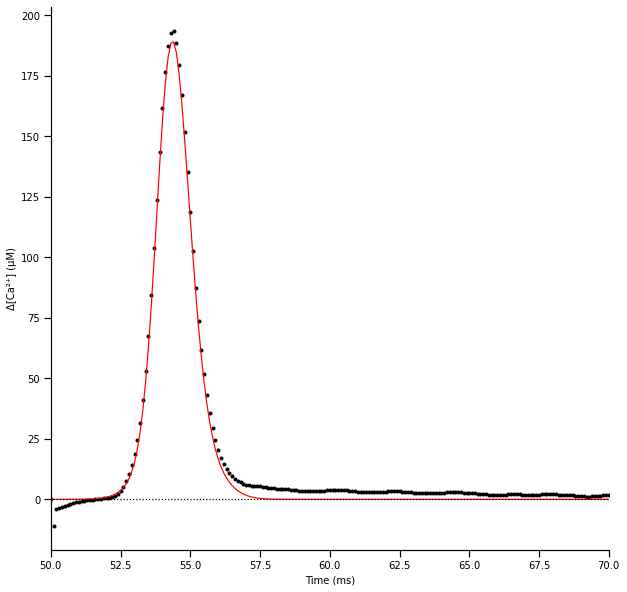

In [40]:
#-*- coding: utf-8-*-
#Ca_Dynamics.py: a spatially-averaged model for Ca dynamics in frog fibers. 
#Description: given furaptras's dFF signal, calculate and plot the Ca dynamics.
#The units of the calculation are in uM and ms; the temperature is 16oC.
#-----------------------------------------------------------------------------
#import requiered libraries for the program
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from fontTools.ttLib import TTFont
import pandas as pd
#-----------------------------------------------------------------------------
#set the font family and size used for the plots
#arialfont1 = TTFont('arial.ttf') #file arial.tff include charaters used in the
#plots such as \u207a (plus as superincex)
#plt.rcParams["font.family"] = "arialfont1"#set arialfont as default font  
#plt.rcParams["font.size"] = 12 #font size (pt)
wd=1.2 # lines and axes spines width (pt)
lma=7 # length of mayor ticks.
lmi=4 # length of minor ticks.
plt.rcParams['axes.spines.top'] = False #remove top axes spines
plt.rcParams['axes.spines.right'] = False #remove rigth axes spines
plt.rcParams['lines.linewidth'] = wd #lines with
plt.rcParams['axes.linewidth'] = wd #set the value globally
plt.rcParams['xtick.major.size'] = lma #length of major x-axis ticks
plt.rcParams['xtick.minor.size'] = lmi #length of minor x-axis ticks
plt.rcParams['ytick.major.size'] = lma #length of major y-axis ticks
plt.rcParams['ytick.minor.size'] = lmi #length of minor y-axis ticks
plt.rcParams['xtick.major.width'] = wd #width of major x-axis ticks
plt.rcParams['xtick.minor.width'] = wd #width of minor x-axis ticks
plt.rcParams['ytick.major.width'] = wd #width of major y-axis ticks
plt.rcParams['ytick.minor.width'] = wd #width of minor y-axis ticks
#-----------------------------------------------------------------------------
def Ca(t): #Ca(t) equals resting [Ca2+](=Ca0) plus the interpolated dCa,
#where dCa is the active [Ca] measurement (which is read in from disc; see
# below)
#Ca(t) is used in the various calls to odeint to solve the time dependent 
#changes
    return Ca0+np.interp(t,time,dCa) #see text for discussion of 'interp' 
#-----------------------------------------------------------------------------
#F_ATP has the formula for the ATP changes during activity (called by odeint)
def F_ATP(y,t):
    dy=[0] #create a list to hold the derivative of interest
    dy[0]=kCaf_ATP*Ca(t)*(1-y[0])-kCar_ATP*y[0]
    return dy
#-----------------------------------------------------------------------------
#F_Dye has the formula for the Dye changes during activity (called by odeint)
def F_Dye(y,t):
    dy=[0] #create a list to hold the derivative of interest
    dy[0]=kCaf_Dye*Ca(t)*(1-y[0])-kCar_Dye*y[0]
    return dy
#-----------------------------------------------------------------------------
#F_Trop has the formula for the Trop changes during activity (called by odeint)
# def F_Trop(y,t):
#     dy=[0] #create a list to hold the derivative of interest
#     dy[0]=kCaf_Trop*Ca(t)*(1-y[0])-kCar_Trop*y[0]
#     return dy
#-----------------------------------------------------------------------------
# #F_Trop has the formulas for Trop changes during activity (called by odeint)
def F_Trop(y,t):
    dy=[0,0] #create a list to hold (d/dt)CaTrop and (d/dt)Ca2Trop
    dy[0]=kCaf1_Trop*Ca(t)*(1-y[0]-y[1])-kCar1_Trop*y[0]\
        +kCar2_Trop*y[1]-kCaf2_Trop*Ca(t)*y[0]
    dy[1]=kCaf2_Trop*Ca(t)*y[0]-kCar2_Trop*y[1]
    return dy
#-----------------------------------------------------------------------------
#F_Parv has the formulas for Parv changes during activity (called by odeint)
def F_Parv(y,t):
    dy=[0,0] #create a list to hold (d/dt)CaParv and (d/dt)MgParv
    dy[0]=kCaf_Parv*Ca(t)*(1-y[0]-y[1])-kCar_Parv*y[0]
    dy[1]=kMgf_Parv*Mg0*(1-y[0]-y[1])-kMgr_Parv*y[1]
    return dy
#-----------------------------------------------------------------------------
#F_SERCA has the formulas for SERCA flux changes during activity (called by 
#odeint)
def F_SERCA(y,t):
    dy=[0] #create a list to hold (d/dt)CaSERCA 
    if Ca(t)>Ca0: #for [Ca2+] higher than [Ca2+] at rest  
        dy=VSERCA*(Ca(t)**hSERCA)/((Ca(t)**hSERCA)+(KdSERCA**hSERCA))
    else: 
        dy=0 #set SERCA flux 0 (uM per ms) when [Ca2+] lower or equal to 
        #[Ca2+] at rest
    return dy   
#-----------------------------------------------------------------------------
#F_NCX has the formulas for NCX flux changes during activity (called by 
#odeint)
def F_NCX(y,t):
    dy=[0] #create a list to hold (d/dt)CaNCX 
    if Ca(t)>Ca0: #for [Ca2+] higher than [Ca2+] at rest  
        dy=((VNCX)\
           *(np.exp(+(((0.5)*dVme*Fc)/(Rc*T)))*((((Na_ex**(3))*Ca(t)))\
           /((KdNa_NCX**(3))*KdCa_NCX)))-(np.exp(-(((0.5)*dVme*Fc)/(Rc*T)))\
           *((((Na_cy**(3))*Ca_ex))/((KdNa_NCX**(3))*KdCa_NCX))))/(1+\
           ((Na_ex**(3))/(KdNa_NCX**(3)))+(Ca(t)/KdCa_NCX)+(((Na_ex**(3))\
           *Ca(t))/((KdNa_NCX**(3))*KdCa_NCX))+((Na_cy**(3))/(KdNa_NCX**(3)))\
           +(Ca_ex/KdCa_NCX)+(((Na_cy**(3))*Ca_ex)/((KdNa_NCX**(3))*KdCa_NCX)))
    else: 
        dy=0 #set NCX flux 0 (uM per ms) when [Ca2+] lower or equal to 
        #[Ca2+] at rest
    return dy
#-----------------------------------------------------------------------------
#F_SOCE has the formulas for SOCE flux changes during activity (called by 
#odeint)
# def F_SOCE(y,t):
#     dy=[0] #create a list to hold (d/dt)CaSOCE 
#     if Ca(t)>Ca0: #for [Ca2+] higher than [Ca2+] at rest  
#         dy=VSOCE*KdSOCE**(hSOCE)/(((Ca(t))**(hSOCE))+(KdSOCE**(hSOCE)))
#     else: 
#         dy=0 #set SOCE flux 0 (uM per ms) when [Ca2+] lower or equal to 
#         #[Ca2+] at rest
#     return dy  
#-----------------------------------------------------------------------------
#F_MCU has the formulas for MCU changes during activity
def F_MCU(t):
    #dy=[0]
    if Ca(t)>Ca0: #for [Ca2+] higher than [Ca2+] at rest  
        dy=-CaMCU0+(VMCU*Ca(t)**hMCU/((Ca(t)**hMCU)+(KdMCU**hMCU)))
    else: 
        dy=0 #set MCU flux 0 (uM per ms) when [Ca2+] lower or equal to 
        #[Ca2+] at rest
    return dy
#-----------------------------------------------------------------------------
#F_NCE has the formulas for NCE flux changes during activity (called by 
#odeint)
def F_NCE(y,t):
    
    if y>Ca0_MITO: #for [Ca2+] higher than [Ca2+] at rest  
        dy=-CaNCE0+(((VNCE)\
            *(np.exp(+(((0.5)*dVmito*Fc)/(Rc*T)))*((((Na_cy**(3))*y))/((KdNa_NCE\
            **(3))*KdCa_NCE)))-(np.exp(-(((0.5)*dVmito*Fc)/(Rc*T)))*((((Na_MITO**(3))*Ca(t)\
            ))/((KdNa_NCE**(3))*KdCa_NCE))))/(1+((Na_cy**(3))/(KdNa_NCE**(3)))+(y\
            /KdCa_NCE)+(((Na_cy**(3))*y)/((KdNa_NCE**(3))*KdCa_NCE))+((Na_MITO**\
            (3))/(KdNa_NCE**(3)))+(Ca(t)/KdCa_NCE)+(((Na_MITO**(3))*Ca(t))/((KdNa_NCE**(3))*\
            KdCa_NCE))))
    else: 
        dy=0 #set NCX flux 0 (uM per ms) when [Ca2+] lower or equal to 
        #[Ca2+] at rest
    return dy

#-----------------------------------------------------------------------------
#F_MITO has the formulas for MITO changes during activity (called by 
#odeint)
def F_MITO(y,t):
    dy=[0,0] #create a list to hold (d/dt)CaB and (d/dt)Ca_MITO
    dy[0]=(kCaf_B*y[1]*(B-y[0]))-(kCar_B*y[0])
    dy[1]=F_MCU(t)-F_NCE(y[1],t)-dy[0] 
    return dy                  
#-----------------------------------------------------------------------------
#set resting [Ca2+] and [Mg2+] 
Ca0=0.106        #resting [Ca2+] in the cytoplasm (uM)
Mg0=780       #resting [Mg2+] in the cytoplasm (uM)
Ca0_SR=1.07e+3   #resting [Ca2+] in the SR (uM)
Ca0_MITO=0.15    #resting [Ca2+] in the MITO (uM)
#-----------------------------------------------------------------------------
#set [ATP] and the reaction rate constants and get resting state for ATP
ATP=8000    #total ATP concentration (uM)
KdCa_ATP=2200   #Ca dissociation constant for site S (uM)
kCaf_ATP=0.1364e-1
kCar_ATP=kCaf_ATP*KdCa_ATP #reverse rate constant for Ca binding to S (per ms)
fCaATP0=Ca0/(Ca0+KdCa_ATP)  #fraction of ATP bound with Ca at rest
#print("\n"+"fCaATP0={:.5f}".format(fCaATP0))
#-----------------------------------------------------------------------------
#set [Dye] and the reaction rate constants and get resting state for Dye
Dye=229.1    #total Dye concentration (uM)
KdCa_Dye=721.07427 #Ca dissociation constant for site S (uM)
kCaf_Dye=1e+1
kCar_Dye=kCaf_Dye*KdCa_Dye #reverse rate constant for Ca binding to Dye (per ms)
fCaDye0=Ca0/(Ca0+KdCa_Dye)  #fraction of Dye bound with Ca at rest
#print("\n"+"fCaATP0={:.5f}".format(fCaATP0))
#-----------------------------------------------------------------------------
#set [Trop] and the reaction rate constants and get resting states for Trop
Trop=120        #total Troponin concentration (uM)
# kCaf_Trop=0.115 
# kCar_Trop=0.023
# KdCa_Trop=kCar_Trop/kCaf_Trop
KdCa1_Trop=8.723#dissociation constant for binding of 1st Ca (uM)
kCaf1_Trop=1.77e-1 #forward rate constant for binding of 1 st Ca (uM)
kCar1_Trop=kCaf1_Trop*KdCa1_Trop #reverse rate constant for 1st bound (per ms)
KdCa2_Trop=0.194    #dissociation constant for binding of 2nd Ca (uM)
kCaf2_Trop=0.885e-1 #forward rate constant for binding of 2nd Ca (uM)
kCar2_Trop=kCaf2_Trop*KdCa2_Trop #reverse rate constant for 2nd bound Ca (per
# ms)
#now calculate the fractional states of trop at rest
# kCar_Trop=kCaf_Trop*KdCa_Trop #reverse rate constant for Ca binding to Dye (per ms)
# fCaTrop0=Ca0/(Ca0+KdCa_Trop)  #fraction of Dye bound with Ca at rest

fTrop0=KdCa1_Trop*KdCa2_Trop/(Ca0*Ca0+Ca0*KdCa2_Trop+KdCa1_Trop*KdCa2_Trop)
fCaTrop0=fTrop0*Ca0/KdCa1_Trop
fCa2Trop0=fCaTrop0*Ca0/KdCa2_Trop
#print("fCaTrop0={:.5f}".format(fCaTrop0))
#print("fCa2Trop0={:.5f}".format(fCa2Trop0))
#-----------------------------------------------------------------------------
#set [Parv] and the reaction rate constants and get resting states for Parv
Parv=1500   #total Parvalbumin concentration (uM)
KdCa_Parv=0.012 #Ca dissociation constant for site S (uM)
kCaf_Parv = 0.417e-1 #forward rate constant for Ca binding to S (per uM per 
#ms)
kCar_Parv = kCaf_Parv*KdCa_Parv #reverse rate constant for Ca binding to S 
#(per ms)
KdMg_Parv=90.9 #Mg dissociation constant for site S (uM)
kMgf_Parv = 3.3e-5 #forward rate constant for Mg binding to S (per uM per ms)
kMgr_Parv = kMgf_Parv*KdMg_Parv #reverse rate constant for Ca binding to S 
#(per ms)
#next calculate the fractional states of parvalbumin at rest
fCaParv0=Ca0/(Ca0+KdCa_Parv*(1+Mg0/KdMg_Parv)) #Ca-binding to Parv (resting)
fMgParv0=Mg0/(Mg0+KdMg_Parv*(1+Ca0/KdCa_Parv)) #Mg-binding to Parv (resting)
#print("fCaParv0={:.5f}".format(fCaParv0))    
#print("fMgParv0={:.5f}".format(fMgParv0))
#-----------------------------------------------------------------------------
# set SERCA maximum rate, dissociation constant and hill coeffient
VSERCA=4.2 #SERCA maximum pump rate (uM per ms)
KdSERCA=0.44 #SERCA dissociation constant (uM)       
hSERCA=2.1 #SERCA hill coefficient (A.U.)
# next calculate the SERCA flux at rest
CaSERCA0=VSERCA*(Ca0**hSERCA)/((Ca0**hSERCA)+(KdSERCA**hSERCA))
#-----------------------------------------------------------------------------
#set NCX maximum rate, membrane potential in resting state, dissociation
#constants of Na+ and Ca+2, cytosolic and extracelular [Na+] and [Ca+2] at
#rest, faraday constant, ideal gas constant and temperature
VNCX=5.46 #maximum flux of NCX (uM per ms).
dVme=180 #membrane potential in resting state (mV)
KdCa_NCX=140 #dissociation constant of Ca+2 to NCX molecules (uM)
KdNa_NCX=14e+3 #dissociation constant of Na+ to NCX molecules (uM)
Na_ex=140e+3 #extracelular [Na+] at rest (uM)
Na_cy=10e+3 #cytosolic [Na+] at rest (uM)
Ca_ex=1.0e+3 #extracelular [Ca+2] at rest (uM)
Fc=96.484 #faraday constant (J per mol per mV)
Rc=8.314 #gas constant (J per mol per K)
T=296.15 #tempeture (K)
# next calculate the NCX flux at rest
CaNCX0=((VNCX)\
*(np.exp(+(((0.5)*dVme*Fc)/(Rc*T)))*((((Na_ex**(3))*Ca0))/((KdNa_NCX**(3))\
*KdCa_NCX)))-(np.exp(-(((0.5)*dVme*Fc)/(Rc*T)))*((((Na_cy**(3))*Ca_ex))\
/((KdNa_NCX**(3))*KdCa_NCX))))/(1+((Na_ex**(3))/(KdNa_NCX**(3)))+(Ca0\
/KdCa_NCX)+(((Na_ex**(3))*Ca0)/((KdNa_NCX**(3))*KdCa_NCX))+((Na_cy**(3))\
/(KdNa_NCX**(3)))+(Ca_ex/KdCa_NCX)+(((Na_cy**(3))*Ca_ex)/((KdNa_NCX**(3))\
*KdCa_NCX)))
#-----------------------------------------------------------------------------
#set SOCE maximum rate, dissociation constants for Ca+2 and hill coefficient                                                       
VSOCE=35e-3 #maximum flux of SOCE (uM per ms).                                                          
hSOCE=4.7 #SOCE hill coefficient (A.U.) 
KdSOCE=0.3e+3 #dissociation constant of Ca+2 to SOCE molecules (uM)     
# next calculate the SOCE flux at rest
CaSOCE0=(VSOCE*KdSOCE**hSOCE)/((Ca0_SR**hSOCE)+(KdSOCE**hSOCE))
#-----------------------------------------------------------------------------
#set mitochondrial parameters
B=2 #total mitochindrial buffer concentration (uM)
kCaf_B=0.8e-3 #forward rate constant for Ca2+ binding to B (per uM per ms)
kCar_B=0.192e-3 #reverse rate constant for Ca2+ binding to B (per ms)
kdCa_B=kCar_B/kCaf_B #Ca2+ dissociation constant for site B (uM)
VNCE=2.8e-3 #maximum flux of NCE (uM per ms).
dVmito=190 #mitochondrial membrane potential in resting state (mV)
KdCa_NCE=1.1 #dissociation constant of Ca+2 to NCX molecules (uM)
KdNa_NCE=8.2e+3 #dissociation constant of Na+ to NCX molecules (uM)
Na_MITO=5e+3 #cytosolic [Na+] at rest (uM)
VMCU=24.5e-3#maximum flux of MCU (uM per ms).
hMCU=2 #MCU hill coefficient (A.U.)
KdMCU=1.2 #dissociation constant of Ca+2 to MCU molecules (uM)
CaB0=Ca0_MITO/(Ca0_MITO+kdCa_B) #[B] bound with Ca2+ at rest (uM)
# next calculate the MCU flux at rest
CaMCU0=(VMCU*Ca0**hMCU)/((Ca0**hMCU)+(KdMCU**hMCU)) 
# next calculate the NCE flux at rest
CaNCE0=((VNCE)\
*(np.exp(+(((0.5)*dVmito*Fc)/(Rc*T)))*((((Na_cy**(3))*Ca0_MITO))/((KdNa_NCE\
**(3))*KdCa_NCE)))-(np.exp(-(((0.5)*dVmito*Fc)/(Rc*T)))*((((Na_MITO**(3))*Ca0\
))/((KdNa_NCE**(3))*KdCa_NCE))))/(1+((Na_cy**(3))/(KdNa_NCE**(3)))+(Ca0_MITO\
/KdCa_NCE)+(((Na_cy**(3))*Ca0_MITO)/((KdNa_NCE**(3))*KdCa_NCE))+((Na_MITO**\
(3))/(KdNa_NCE**(3)))+(Ca0/KdCa_NCE)+(((Na_MITO**(3))*Ca0)/((KdNa_NCE**(3))*\
KdCa_NCE)))                                                          
#-----------------------------------------------------------------------------    
#read in the Mag-Fluo-4 measurement in mouse fibers activated by one AP    
data=np.array(pd.read_excel('inputs/f2b.xlsx'))#load the averaged dF measurement into 'data' 
t_start=1;t_end=1490#select time points 200 to 1490 for the analysis
time=data[t_start:t_end,0] #the time used to interp base goes from 50 to 110 ms
tsim=np.arange(50,110,0.1) #the time used for simulation goes from 50 to#
# 110 ms with intervals of 0.1 ms 
F=data[t_start:t_end,1] #get the fluorescence values for the selected time base
#-----------------------------------------------------------------------------
Fmin=0.14 #minimum fluorescence (A.U.)
pF=6.3635 #peak of fluorescence during one AP (A.U.)
DT=229.1 #total Dye concentration (uM)
Fmax=150.9 #maximum fluorescence (A.U.)
Kd=1.652e+05 #disociation constant (uM2)
#-----------------------------------------------------------------------------
#Convertion of the F signal into dCa
F=(pF*((F)/np.max(F)))+Fmin #reescale the F signal.
dCa=(Kd/DT)*(((F-Fmin)*(Fmax-Fmin))/(2*((Fmax-F)**2))) #get the concentration 
#from the F trace
dCatsim=Ca(tsim)-Ca0 #calculate change of [Ca2+] as a funtion of tsim
#-----------------------------------------------------------------------------
#next calculate the active responses of ATP, Trop, Parv and Pump to the dCa
#signal; to get the changes during activity need to subtract the 
#resting-state values  

#set initial conditions and call odeint for ATP; then correct for resting
#state
y_init=[fCaATP0] #set initial conditions for odeint call for ATP
y=odeint(F_ATP,y_init,tsim,rtol=1e-10) #call to solve the deq
CaATP=(y[:,0]-fCaATP0)*ATP #first column contains the solution for fCaATP

#set initial conditions and call odeint for Dye; then correct for resting
#state
y_init=[fCaDye0] #set initial conditions for odeint call for ATP
y=odeint(F_Dye,y_init,tsim,rtol=1e-10) #call to solve the deq
CaDye=(y[:,0]-fCaDye0)*Dye #first column contains the solution for fCaATP

#set initial conditions and call odeint for Dye; then correct for resting
#state
# y_init=[fCaTrop0] #set initial conditions for odeint call for ATP
# y=odeint(F_Trop,y_init,tsim,rtol=1e-10) #call to solve the deq
# CaTrop=(y[:,0]-fCaTrop0)*Trop #first column contains the solution for fCaATP

# #set initial conditions and call odeint for Trop; then correct for resting
# #state
y_init=[fCaTrop0,fCa2Trop0] #set initial conditions for odeint call for Trop
y=odeint(F_Trop,y_init,tsim,rtol=1e-10) #call to solve the deq's
CaTrop=(y[:,0]-fCaTrop0)*Trop #first column contains the solution for fCaTrop
Ca2Trop=(y[:,1]-fCa2Trop0)*Trop #second column contains the solution for
#fCa2Trop

#set initial conditions and call odeint for Parv; then correct for resting
#state
y_init=[fCaParv0,fMgParv0] #set initial conditions for odeint call for Parv
y=odeint(F_Parv,y_init,tsim,rtol=1e-11) #call to solve the deq's
CaParv=(y[:,0]-fCaParv0)*Parv #first column contains the solution for fCaParv
MgParv=(y[:,1]-fMgParv0)*Parv #second column contains the solution for fMgParv

#set initial conditions and call odeint for SERCA; then correct for resting
#state
y_init=[CaSERCA0] #set initial conditions for odeint call for SERCA
y=odeint(F_SERCA,y_init,tsim,rtol=1e-10) #call to solve the deq F_SERCA
CaSERCA=(y[:,0]-CaSERCA0) #first column contains the solution for CaSERCA

#set initial conditions and call odeint for SERCA; then correct for resting
#state
y_init=[CaNCX0] #set initial conditions for odeint call for NCX
y=odeint(F_NCX,y_init,tsim,rtol=1e-10) #call to solve the deq F_NCX
CaNCX=(y[:,0]-CaNCX0) #first column contains the solution for CaSERCA

#set initial conditions and call odeint for MITO; then correct for resting
#state
y_init=[CaB0,Ca0_MITO] #set initial conditions for odeint call for Parv
y=odeint(F_MITO,y_init,tsim,rtol=1e-10) #call to solve the deq's
CaB=(y[:,0]-CaB0) #first column contains the solution for CaB
Ca_MITO=(y[:,1]-Ca0_MITO) #second column contains the solution for Ca_MITO
#-----------------------------------------------------------------------------
#d[CaTotal] is the sum of d[Ca] plus all d[CaSite] plus the Ca removed by 
#pumping. Thus d[CaTotal] is the amount of Ca released into the myoplasm
#during activity
CaTotal=CaATP+CaDye+(0.88*CaTrop)+((0.88*2*Ca2Trop))+CaParv+dCatsim+CaSERCA 
#-----------------------------------------------------------------------------
#calculate the rate of SR Ca release
CaRelease=1.*CaTotal #'1.*' makes sure space is allocated for a new array
CaRelease[0]=0
for i in range(1,CaTotal.size):
    dt=tsim[i]-tsim[i-1]
    CaRelease[i]=(CaTotal[i]-CaTotal[i-1])/dt

CaReleaseTime=[tsim,CaRelease]
df=pd.DataFrame(CaReleaseTime)
df=df.T
filepath = 'CaReleaseTime.xlsx'
df.to_excel(filepath, index=False,header=False)
#-----------------------------------------------------------------------------    
def gauss3(x,a1,b1,c1,a2,b2,c2,a3,b3,c3):
    y=+(a1*np.exp(-((x-b1)/c1)**2))\
       +(a2*np.exp(-((x-b2)/c2)**2))\
       +(a3*np.exp(-((x-b3)/c3)**2))
    return y
#-----------------------------------------------------------------------------
a1=-101.4
b1=54.59   
c1=0.6696   
a2=245.2   
b2=54.46   
c2=0.7623   
a3=39.92   
b3=54.61   
c3=1.343   
#-----------------------------------------------------------------------------

CaReleaseFitted=gauss3(tsim,a1,b1,c1,a2,b2,c2,a3,b3,c3)
#-----------------------------------------------------------------------------
#now do the plotting; all plotted traces will have a dotted baseline
base_x=np.array([time[0],time[-1]]) #get x-values of a baseline for all plots
base_y=np.zeros(2) #get y-values of a baseline for all plots
#-----------------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(4, 2))
# ax.plot(tsim,dCatsim,'k')
# ax.set_ylim([-1,19])
# ax.set_xlim([50,110])
# ax.set_xlabel('Time (ms)')
# ax.set_ylabel('\u0394[Ca\u00b2\u207a] (\u03BCM)')
# ax.set_xticks([60,80,100])
# ax.yaxis.set_minor_locator(ticker.FixedLocator([4,12]))
# ax.xaxis.set_minor_locator(ticker.FixedLocator([70,90]))
# ax.set_yticks([0,8,16])
# fig.savefig("figs/dCa.pdf",bbox_inches='tight',pad_inches=0,transparent=True)
#-----------------------------------------------------------------------------
 
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(tsim,CaRelease,'k.')
ax.plot(tsim,CaReleaseFitted,'r')
ax.plot(base_x,base_y,':k')
#ax.set_ylim([-1,19])
ax.set_xlim([50,70])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('\u0394[Ca\u00b2\u207a] (\u03BCM)')
 
# ax.set_xticks([60,80,100])
# ax.yaxis.set_minor_locator(ticker.FixedLocator([4,12]))
# ax.xaxis.set_minor_locator(ticker.FixedLocator([70,90]))
# ax.set_yticks([0,8,16])
# fig.savefig("figs/dCa.pdf",bbox_inches='tight',pad_inches=0,transparent=True)
#-----------------------------------------------------------------------------
# plt.figure(figsize=(4, 2))
# plt.plot(time,CaATP,'k')
# plt.xlabel('Time (ms)')
# plt.xticks([60, 80, 100])
# #plt.axes().xaxis.set_minor_locator(MultipleLocator(10))
# plt.ylabel('\u0394[CaATP] (\u03BCM)')
# plt.savefig("figs/CaATP.svg",dpi=200, transparent=True)
# #-----------------------------------------------------------------------------
# plt.figure(figsize=(4, 2))
# plt.plot(time,CaParv,'k')
# plt.xlabel('Time (ms)')
# plt.xticks([60, 80, 100])
# #plt.axes().xaxis.set_minor_locator(MultipleLocator(10))
# #plt.axes().yaxis.set_minor_locator(MultipleLocator(5))
# plt.ylabel('\u0394[CaParv] (\u03BCM)')
# plt.savefig("figs/CaParv.svg",dpi=200, transparent=True)
# #-----------------------------------------------------------------------------




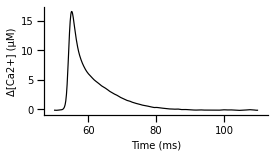

In [36]:

#-------------------------------------------------------------------------------------------------------------------
def Ca(t,time,dCa): #Ca(t) equals resting [Ca2+](=Ca0) plus the interpolated dCa,where dCa is the active [Ca] measurement
# (which is read in from disc; see below) Ca(t) is used in the various calls to odeint to solve the time dependent 
# changes
    return Ca0+np.interp(t,time,dCa) #see text for discussion of 'interp' 
#-------------------------------------------------------------------------------------------------------------------    
#read in the Mag-Fluo-4 measurement in mouse fibers activated by one AP
df=np.array(pd.read_excel('inputs/f2b.xlsx'))#load the averaged dF measurement into 'data' 
t_start=1;t_end=1490#select time points 200 to 1490 for the analysis
time=df[t_start:t_end,0] #the time used to interp base goes from 50 to 110 ms
tsim=np.arange(50,110,0.1) #the time used for simulation goes from 50 to 110 ms with intervals of 0.1 ms 
F=df[t_start:t_end,1] #get the fluorescence values for the selected time base
#-----------------------------------------------------------------------------
Fmin=0.14 #minimum fluorescence (A.U.)
pF=6.3635 #peak of fluorescence during one AP (A.U.)
DT=229.1 #total Dye concentration (uM)
Fmax=150.9 #maximum fluorescence (A.U.)
Kd=1.652e+05 #disociation constant (uM2)
#-----------------------------------------------------------------------------
#Convertion of the F signal into dCa
F=(pF*((F)/np.max(F)))+Fmin #reescale the F signal.
dCa=(Kd/DT)*(((F-Fmin)*(Fmax-Fmin))/(2*((Fmax-F)**2))) #get the concentration from the F trace
dCatsim=Ca(tsim,time,dCa)-Ca0 #calculate change of [Ca2+] as a funtion of tsim
#-----------------------------------------------------------------------------
plt.figure(figsize=(4, 2))
plt.plot(tsim,dCatsim,'k')
plt.xlabel('Time (ms)')
plt.xticks([60, 80, 100])
#plt.axes().xaxis.set_minor_locator(MultipleLocator(10))
plt.ylabel('\u0394[Ca2+] (\u03BCM)')
#plt.savefig("figs/CaATP.svg",dpi=200, transparent=True)
plt.show()



array([ 3.56e+01, -1.94e-03])